<a href="https://colab.research.google.com/github/CrisFiss/dataset-idiomas/blob/master/Language_Identification_FES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Daniel Vasilyonok</h2>
<h3>Python for Data Science CSCI E - 29</h3>
<h3>Natural Language Identification Machine Learning Pipeline - Graduate Project</h3>

<p>
In this project, I pulled text data from European Parliament Proceedings in 21 languages.
Using Scikit-Learn, I transformed the raw text into a numerical feature matrix, and trained
a Multinomial naive bayes probability model to classify input language with greater than 99% accuracy.
</p>

<p> 
Data Source: http://www.statmt.org/europarl/    
</p>

In [0]:

# Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

In [0]:

# regular expression pattern used to filter out anything between < >
# Non predictive speaker information in english is always in between those two symbols

pattern = r'<(!?).*>'

# Max length of language transcription
# Ensure each language has similar amount of representation (Balanced Dataset)
MAX_LENGTH_TRANSCRIPTION = 150000

In [0]:

# Map language index to natural language

labels = { 
          1.0:'German',
          2.0: 'English', 
          3.0: 'Spanish'
          }

# Map language to language code and file name

language_codes_files = {
    'German': ['de', '/ep-00-01-17.txt'], 
    'English': ['en', '/ep-00-01-17.txt'], 
    'Spanish': ['es', '/ep-00-01-17.txt']
}

# These languages need multiple files combined to get a transcription of length
# >= MAX_LENGTH_TRANSCRIPTION
limited_raw_text = []


<h2>Helper Functions</h2>

In [0]:
# Helper Functions

def combine_text_files(language_code, language):
   
    '''
    Goal: Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
          This function will combine these files for this sort of language into one language
          transcription, and then write the transcription to a single file.
    
    @param: (string) language_code is the 2 character code of the language
    @param: (string) language is the English name of the language         
    '''    
    
    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if(len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path, 'r', errors='ignore') as f:
            contents = f.read()
            language_transcription += contents
    
    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w', errors='ignore') as f:
        f.write(language_transcription)

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
                 Original file data source found here: http://www.statmt.org/europarl/
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path, 'r', errors='ignore') as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern,'',sentence)

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of strings that has had speaker information filtered out
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0],1)
    target = np.zeros((sentences.shape[0],1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    true_values = np.array(true_values)
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def shuffle_rows(languages):
    '''
    Goal: Shuffle rows of 2D np.array with language data
    
    @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
    @return shuffled_languages: shuffled by row, 2D np.array 
    '''
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index,:]

    return shuffled_languages
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict( (key, language_codes_files[key] ) for key in limited_raw_text if key in language_codes_files )
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)
    
    # Read all raw text data from file paths
    language_transcriptions = [ read_languages_data(path) for path in file_paths ]
    
    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)
    
    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)
    
    # Combine each language with its language_index
    languages = [ combine_language_data(sentences,i+1) for i,sentences in enumerate(language_transcriptions) ]
    
    # Vertically stack all data into one 2D np.array
    languages =  np.vstack((languages))
    
    # Shuffle languages by row
    languages = shuffle_rows(languages)
    
    return languages
    

In [0]:
# Get all file paths

file_paths = [ os.getcwd() + '/language_data/txt/' + language_codes_files[language][0] + language_codes_files[language][1] for language in language_codes_files ]

# Preprocess all raw text into a form suitable for TfidfVectorizer
languages = preproccess_raw_data(file_paths)
languages

array([['Todo el mundo, seÃ±ora ponente, SeÃ±orÃ\xadas, comprende las razones, las demoras -volverÃ© sobre ellas en un momento- , y sean lo que sean esas demoras o esos retrasos, en vista de que ahora discutimos este informe, considero, en nombre de la ComisiÃ³n, que llega en buen momento, pues se tata de las orientaciones 2000-2006, porque en este momento iniciamos la nueva programaciÃ³n regional\n\nLa ponente ha recordado con justeza que, aunque sobre todo incumbe a los Estados miembros y a las regiones definir sus propias prioridades en materia de desarrollo, la cofinanciaciÃ³n de los programas por la UniÃ³n Europea exige y justifica que tambiÃ©n se tengan en cuenta las prioridades comunitarias tal como se debatieron y aprobaron aquÃ\xad, para promover esa dimensiÃ³n comunitaria de la cohesiÃ³n econÃ³mica y social que muchos diputados han recordado con insistencia.',
        '3.0'],
       ["\n(Applause from the PSE Group)\n\n\nMadam President, I really am quite astonished at Mr Bar

In [0]:
df_languages = pd.DataFrame(languages)
df_languages.columns = ['natural language', 'language index']
df_languages['language index'] = df_languages['language index'].apply(float)
df_languages['language'] = df_languages['language index'].map(labels)
print(df_languages.isnull().any())
display(df_languages.head(10))

natural language    False
language index      False
language            False
dtype: bool


,natural language,language index,language
0,"Todo el mundo, seÃ±ora ponente, SeÃ±orÃ­as, co...",3.0,Spanish
1,\n(Applause from the PSE Group)\n\n\nMadam Pre...,2.0,English
2,"\n SeÃ±ora Presidenta, si en el registro de la...",3.0,Spanish
3,"Ich weiÃŸ nicht, ob diese Information richtig ...",1.0,German
4,"\nYo como austrÃ­aco, pero creo que todos noso...",3.0,Spanish
5,"Y en la revisiÃ³n, en la asignaciÃ³n de las re...",3.0,Spanish
6,"Die erste bezieht sich darauf, daÃŸ bedeutsame...",1.0,German
7,Ich mÃ¶chte bei dieser Gelegenheit nur darauf ...,1.0,German
8,\nDie erste Herausforderung ist die Harmonisie...,1.0,German
9,"Meine Frage betrifft eine Angelegenheit, die a...",1.0,German


In [0]:
df_languages.shape

(2630, 3)

In [0]:
# Split data into raw features and labels

language_features = df_languages['natural language']
language_targets = df_languages['language index']

Ensure Dataset is relativley balanced.

In [0]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{1.0: 896, 2.0: 890, 3.0: 844}

In [0]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.3,
                                                    random_state = 42)

<h2>Machine Learning Pipeline</h2>

<h3>Feature Engineering / Preprocessing</h3>
<p>With the clean raw text sentences in hand, the natural languages are preprocessed using Scikit-Learn's
TfidfVectorizer. Essentially, the raw text sentences are converted into a numerical feature matrix.
Tfidf stands for Term frequency inverse document frequency, and the arguments I used are analyzer = 'char' and
ngram_range = (1,3). Analyzer = 'char' tells the vectorizer to look at characters rather than words. 
ngram_range = (1,3) tells the vectorizer to assign tfidf scores to character sequences with max length of 3 characters
and minimum length of 1 character. From doing some linguistic reasearch, I found that short character ngram sequences
are predictive features of a natural languages.
<br>
<br>
<b>How does TfidfVectorizer work in this situation?</b>
<p>The count of each ngram is recorded and divided by the total ngrams in a sentence.
This number is the tf (Term Frequency) in tfidf. Next, the term frequency is scaled down 
by being multiplied by how common it is in all sentences. This factor used by TfidfVectorizer in Scikit-Learn is
1 + log(# sentences / # of sentences that contain the ngram). If an ngram is highly reccurent in many sentences, this
inverse document frequency term (idf) gets smaller, and brings down the overall tfidf score. The idf term makes it so that words like the,of, or frequently used articles do not have too much weight in an ngram's score. The output of TfidfVectorizer is a numerical feature matrix that has maps the ngram index to its tfidf score. This can be passed into a Machine Learning model.</p>
<h3>Naive Bayes Multinomial Model</h3>
<p> In a Naive Bayes Multinomial Model, features are assumed to be generated from a multinomial distribution, rather than the slightly more simple Gaussian Naive Bayes model that assumes features are generated from a Gaussian distribution. The Multinomial Naive Bayes model is modeled with the best fit multinomial distribution. The model
works by computing a large table of probabilities with the given data. Using the Liklihood -- P(feature|Label), the Prior-- P(Label), and the Marginal Liklihood-- P(feature), the model takes advatage of Baye's Theorm to compute 
P(Label|feature). The P(Label|feature) with the highest probability gets predicted as the correct language.
</p>

In [0]:

# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [0]:

# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [0]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [0]:

# Measure accuracy

accuracy_score(y_test,predictions)

0.9987325728770595

<h1>Cross Validated Accuracy</h1>

In [0]:

# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.9980988593155894


<h1>Classification Report</h1>

In [0]:
print(classification_report(y_test, predictions, target_names=labels.values()))

              precision    recall  f1-score   support

      German       1.00      1.00      1.00       269
     English       1.00      1.00      1.00       253
     Spanish       1.00      1.00      1.00       267

    accuracy                           1.00       789
   macro avg       1.00      1.00      1.00       789
weighted avg       1.00      1.00      1.00       789



[Text(0, 0.5, 'German'), Text(0, 1.5, 'English'), Text(0, 2.5, 'Spanish')]

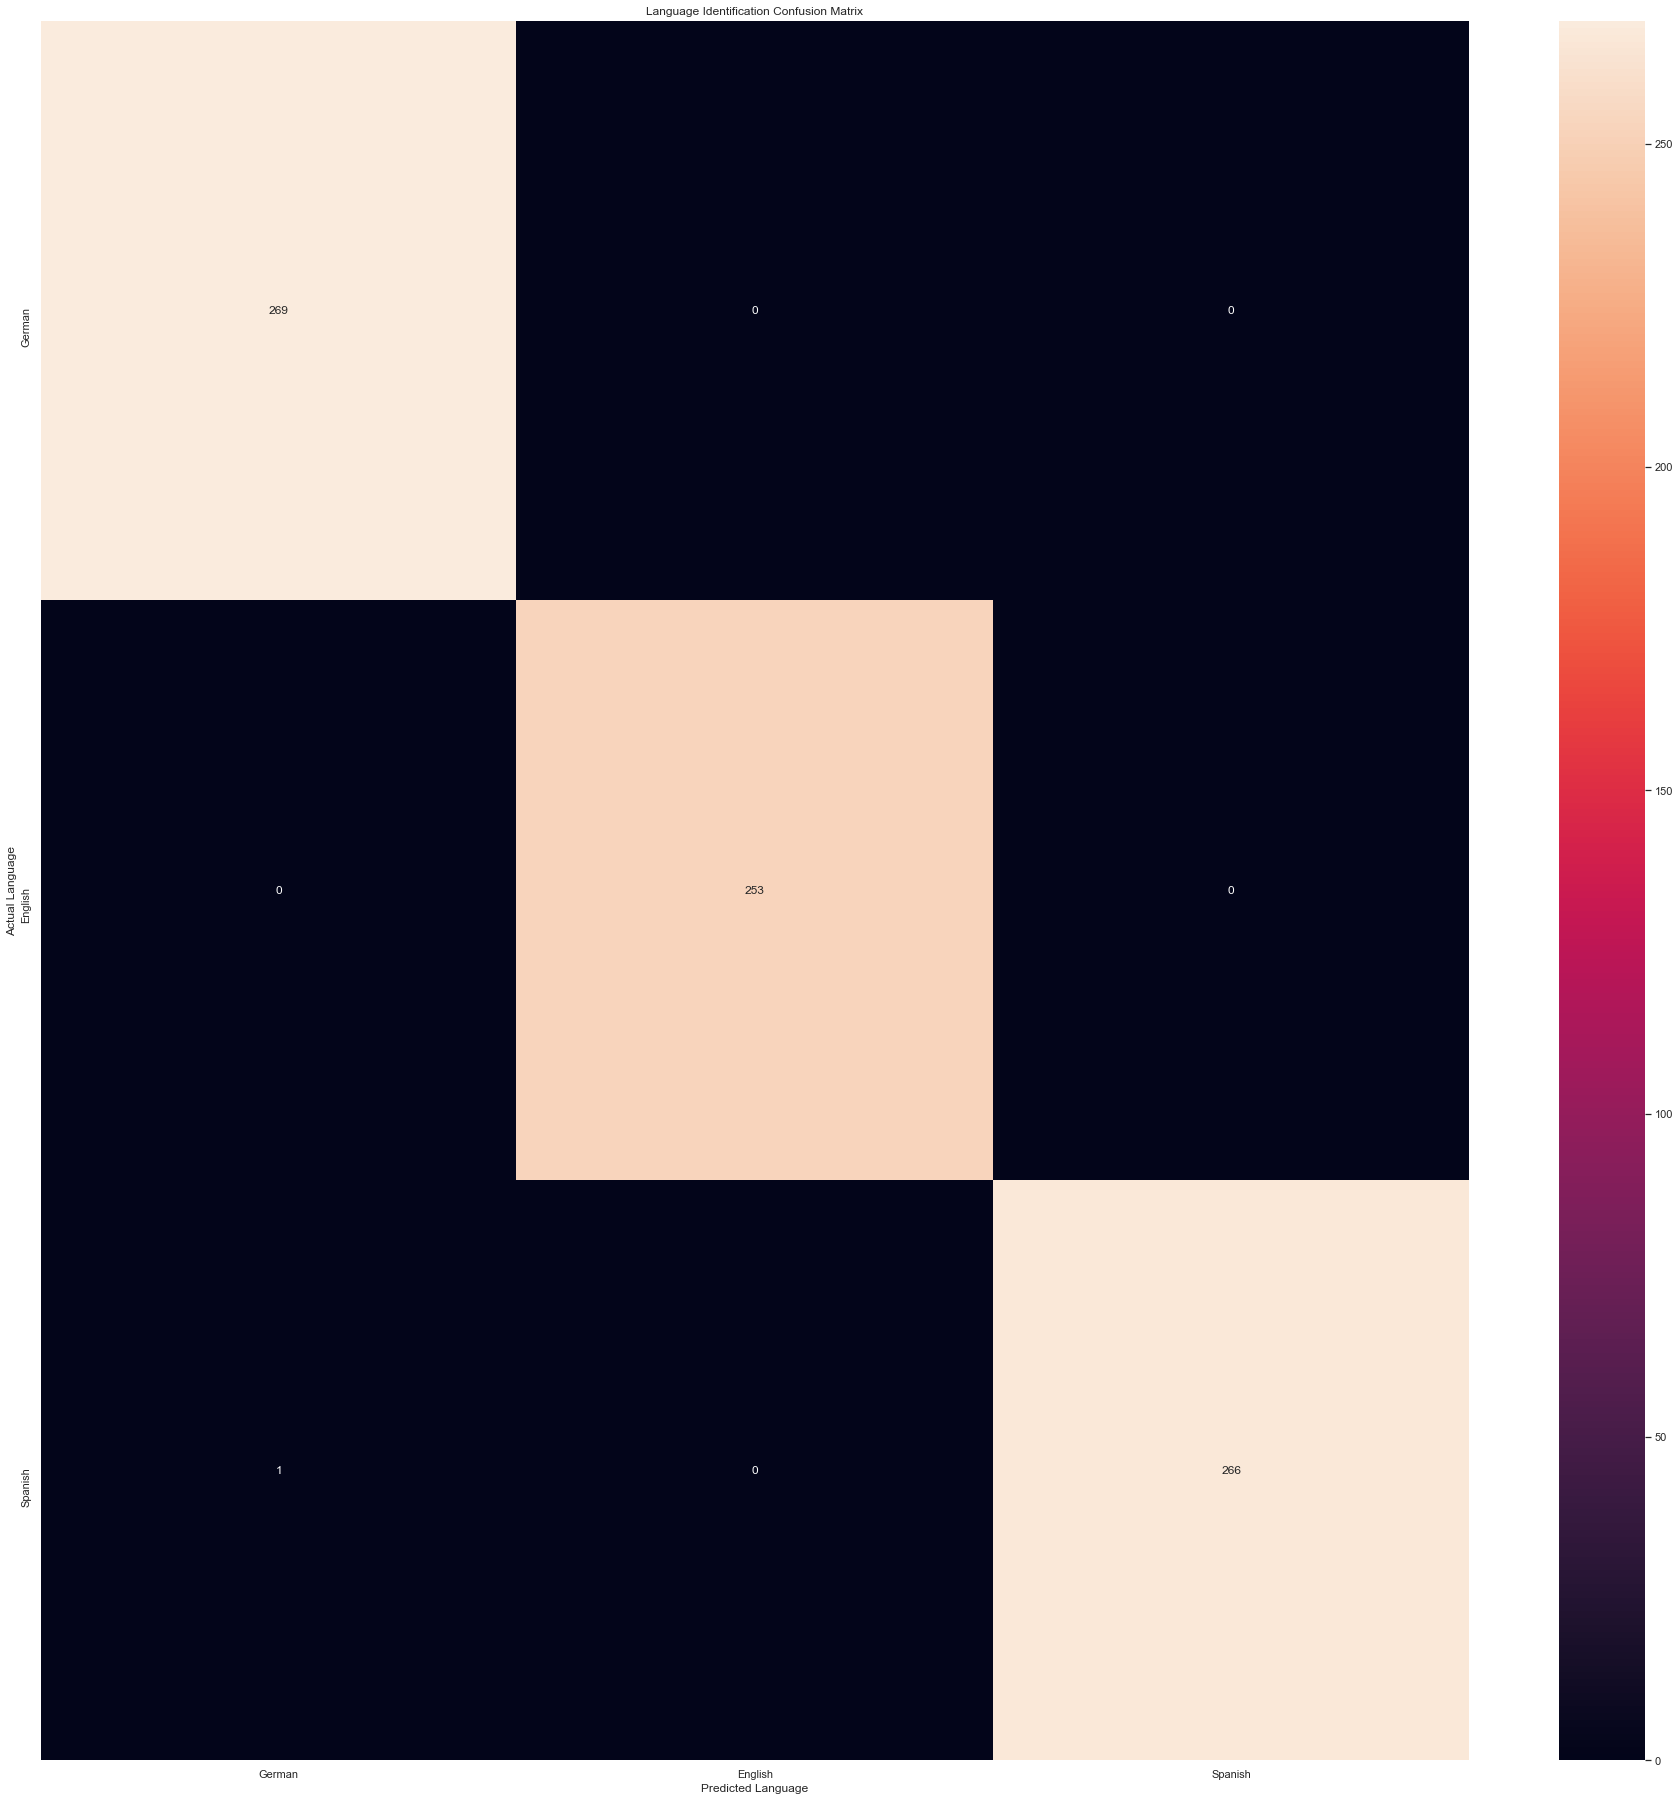

In [0]:
language_names = list(language_codes_files.keys())
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

<h1> 21x21 Confusion Matrix</h1>

<p> 
The well defined diagonal is a visual representation 
of the good performance of this language classifier.
Although this model performs quite well, there are a few misclassifications.
The confusion matrix gives insight into where the model makes errors.
</p>

In [0]:
plt.show()

In [0]:
# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: German
Actual Language: German
Input Sentence: 

Ich will zum Ausdruck bringen, daÃŸ die Sicherheit ein vorrangiges Ziel der Kommission ist.


Prediction: English
Actual Language: English
Input Sentence: 
I know many have already done so, but she has indeed earned our praise for being particularly open and attentive to proposals from all sides, and I think it is this openness which has given her report the quality we see today.


Prediction: German
Actual Language: German
Input Sentence: 
Sehr geehrte Kollegen!


Prediction: English
Actual Language: English
Input Sentence: 

The European Commission' s sixth report presents very valuable conclusions.


Prediction: German
Actual Language: German
Input Sentence: 

Herr PrÃ¤sident, Herr Kommissar Barnier, liebe Kolleginnen und Kollegen!


Prediction: German
Actual Language: German
Input Sentence: 
Vor wenigen Augenblicken sprach Herr Vatanen von Temperaturen, die nicht nur unter 20 Grad minus, sondern unter 40 Grad minus liegen

Input Sentence: 

En nuestras enmiendas hemos fijado la importancia que para nosotros tiene el que se produzcan las necesarias sinergias entre los Fondos estructurales, el Fondo de CohesiÃ³n y las iniciativas comunitarias, de forma que su aplicaciÃ³n se vea reflejada de manera Ã³ptima, de la manera mÃ¡s rentable, en la progresiva eliminaciÃ³n de desigualdades entre regiones y en la creaciÃ³n de puestos de trabajo que, en definitiva, son los dos propÃ³sitos fundamentales de los fondos de los que estamos hablando.


Prediction: German
Actual Language: German
Input Sentence: 

In unseren Ã„nderungsantrÃ¤gen haben wir festgeschrieben, welche Bedeutung wir der Herausbildung der notwendigen Synergien zwischen den Strukturfonds, dem KohÃ¤sionsfonds und den Gemeinschaftsinitiativen beimessen, so daÃŸ ihre Anwendung auf optimale und rentabelste Weise im zunehmenden Abbau der regionalen Ungleichheiten und in der Schaffung von ArbeitsplÃ¤tzen ihren Niederschlag findet, die letztendlich die beiden

In [0]:
# Twitter data

pred = text_clf.predict(['I\'ve #got a feeling! 👌'])

labels[float(pred[0])]

'English'